In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import dynamic_range_nms
from utils.set_seed import seed_base
from feature_engineering.stage2 import generate_2nd_stage_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ensemble"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ensemble']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-25 11:00:49.127269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 11:00:49.193423: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-25 11:00:49.637632: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_084


In [2]:
oof_df = pd.read_parquet(f'/kaggle/output/{CFG["patch_model"]["execution"]["best_exp_id"]}/oof.parquet')
# oof_df = oof_df[oof_df["series_id"].isin(oof_df["series_id"].unique()[:50])]
oof_df.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.001423,0.000193
1,05e1944c3818,18,0.001385,0.000224
2,05e1944c3818,30,0.001297,0.000247
3,05e1944c3818,42,0.001260,0.000309
4,05e1944c3818,54,0.001197,0.000346


987895

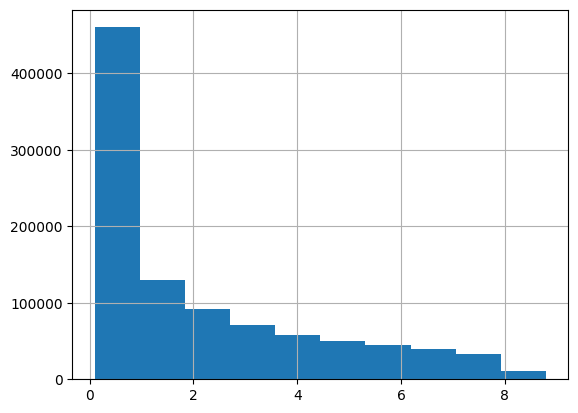

In [3]:
dfs = []
df = oof_df[["series_id", "step", "wakeup_oof"]]
df = df[df["wakeup_oof"] > 0.1]
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = oof_df[["series_id", "step", "onset_oof"]]
df = df[df["onset_oof"] > 0.1]
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs).reset_index(drop=True)
train["step"] = train["step"].astype(int)
train["score"].hist()
len(train)

In [4]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import sys
import yaml
import matplotlib.pyplot as plt
import gc
from typing import Optional
from scipy.interpolate import interp1d

RANGE = 360
COEFF = 10
EXP = 2

def dynamic_range_nms(df: pd.DataFrame) -> pd.DataFrame:
    """Dynamic-Range NMS

    Parameters
    ----------
    df : pd.DataFrame
        単一のseries_idに対する提出形式
    """
    df = df.sort_values("score", ascending=False).reset_index(drop=True)
    used = []
    used_scores = []
    reduce_rate = np.ones(df["step"].max() + 1000)
    for _ in range(min(len(df), 500)):
        df["reduced_score"] = df["score"] / reduce_rate[df["step"]]
        best_score = df["reduced_score"].max()
        best_idx = df["reduced_score"].idxmax()
        best_step = df.loc[best_idx, "step"]
        used.append(best_idx)
        used_scores.append(best_score)

        for r in range(1, int(RANGE)):
            reduce = ((RANGE - r) / RANGE) ** EXP * COEFF
            reduce_rate[best_step + r] += reduce
            if best_step - r >= 0:
                reduce_rate[best_step - r] += reduce
        reduce_rate[best_step] = 1e10
    df = df.iloc[used].copy()
    df["reduced_score"] = used_scores
    return df


In [5]:
from multiprocessing import Pool
import optuna

def objective(trial):
    global RANGE, COEFF, EXP
    RANGE = trial.suggest_int("RANGE", 100, 1000)
    COEFF = trial.suggest_int("COEFF", 1, 30)
    EXP = trial.suggest_int("EXP", 1, 5)        

    groups = [group for _, group in train.groupby("series_id")]
    with Pool(30) as p:  
        results = list(p.imap(dynamic_range_nms, groups))
    sub = pd.concat(results)
    sub["score"] = sub["reduced_score"]

    # スコア計算
    labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
    # labels = labels[labels["series_id"].isin(sub["series_id"].unique())].reset_index(drop=True)
    score, ap_table = compute_comptetition_metric(labels, sub)
    return score


study = optuna.create_study(direction="maximize")
study.enqueue_trial({"RANGE": 695, "COEFF": 14, "EXP": 3})
study.enqueue_trial({"RANGE": 360, "COEFF": 10, "EXP": 2})
study.enqueue_trial({"RANGE": 638, "COEFF": 17, "EXP": 3})
study.enqueue_trial({"RANGE": 570, "COEFF": 5, "EXP": 3})
study.optimize(objective, n_trials=60)
print(study.best_params)

[I 2023-10-25 11:00:52,280] A new study created in memory with name: no-name-745ed625-7d5c-48d3-aaca-5cdc73c692e8
[I 2023-10-25 11:05:36,996] Trial 0 finished with value: 0.7779253280972201 and parameters: {'RANGE': 695, 'COEFF': 14, 'EXP': 3}. Best is trial 0 with value: 0.7779253280972201.
[I 2023-10-25 11:10:22,543] Trial 1 finished with value: 0.7728967901005379 and parameters: {'RANGE': 360, 'COEFF': 10, 'EXP': 2}. Best is trial 0 with value: 0.7779253280972201.
[I 2023-10-25 11:15:08,176] Trial 2 finished with value: 0.7777122264673051 and parameters: {'RANGE': 638, 'COEFF': 17, 'EXP': 3}. Best is trial 0 with value: 0.7779253280972201.
[I 2023-10-25 11:19:53,682] Trial 3 finished with value: 0.7759640551842897 and parameters: {'RANGE': 570, 'COEFF': 5, 'EXP': 3}. Best is trial 0 with value: 0.7779253280972201.
[I 2023-10-25 11:24:38,357] Trial 4 finished with value: 0.7654121280393447 and parameters: {'RANGE': 383, 'COEFF': 12, 'EXP': 5}. Best is trial 0 with value: 0.7779253280

KeyboardInterrupt: 

---